In [3]:
%matplotlib notebook

In [279]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
import pickle
import time
from functools import partial
from importlib import reload
from collections import defaultdict
from itertools import groupby

import numpy as np
import tensorflow as tf
print(tf.__version__)
from matplotlib import pyplot as plt
plt.ion()

import logging
logging.getLogger("tensorflow").setLevel(logging.WARNING)

1.12.0


In [280]:
# Add simlink to load old pickled results
import sys
from include import dataset_utils
from include import tfrecords_utils
from include import preprocess_utils
from include import graph_manager
from include import viz_utils

sys.modules['dataset_utils'] = dataset_utils
sys.modules['tfrecords_utils'] = tfrecords_utils
sys.modules['preprocess_utils'] = preprocess_utils
sys.modules['graph_manager'] = graph_manager

## Utils

In [281]:
def restore_start(i, model_scopes):
    """Returns saver that restore a model up to layer i (excluded)"""
    start = ['^%s/' % x for x in model_scopes[:i]]
    end = ['^%s/' % x for x in model_scopes[i:]]
    vars_start = tf.contrib.framework.get_variables_to_restore(include=start, exclude=end)
    vars_end = tf.contrib.framework.get_variables_to_restore(include=end, exclude=start)    
    if len(vars_start) and len(vars_end):
        return tf.train.Saver(vars_start), tf.train.Saver(vars_end)
    elif len(vars_start) == 0:
        return None, tf.train.Saver(vars_end)
    elif len(vars_end) == 0:
        return tf.train.Saver(vars_start), None

def restore_pointwise(i, model_scopes):
    """Returns saver that only restore only layer i"""
    if i >= 0:
        point = ['^%s/' % model_scopes[i]]
        rest = ['^%s/' % x for x in (model_scopes[:i] + model_scopes[i + 1:])]
        vars_point = tf.contrib.framework.get_variables_to_restore(include=point, exclude=rest)
        vars_rest = tf.contrib.framework.get_variables_to_restore(include=rest, exclude=point)
        return tf.train.Saver(vars_point), tf.train.Saver(vars_rest)
    else: 
        rest = ['^%s/' % x for x in model_scopes]
        vars_rest = tf.contrib.framework.get_variables_to_restore(include=rest)
        return None, tf.train.Saver(vars_rest)

In [282]:
def accuracy_metric_plot(fig,
                         ax,
                         setting_factory, 
                         classifier_constructor_fn,
                         save_log_path,
                         ratio=1.0,
                         restore_fn=restore_pointwise,
                         batch_size=32,
                         split='val',
                         verbose=False):
    """Plot accuracy-based layer selection criterion"""
    settings = [x for x in setting_factory.variant_settings 
                if x.name not in ['blurry_photo', 'noisy_photo']]
    base_setting = setting_factory.base_setting
    base_log_dir = tf.train.latest_checkpoint(setting_factory.get_base_checkpoint_dir())
    num_layers = len(classifier_constructor_fn.model_scopes)
    
    # Initialize Figure
    lines = [ax.plot([], [], marker='o', zorder=1)[0] for setting in settings]
    ax.set_facecolor((0.92, 0.92, 0.92))
    ax.set_title('Ratio  %.3f' % ratio)
    ax.set_xlabel('Layers')
    if (num_layers <= 7 and ratio == 0.001) or (num_layers == 13 and ratio == 0.01):
        ax.set_ylabel('Average accuracy')
    ax.set_ymargin(0.1)
    fig.canvas.draw()
    print('\n\n\u001b[93mRatio: %.4f\u001b[0m' % ratio)
    
    # Number of layers and scale depending on the mode
    if restore_fn == restore_start:
        layers = range(num_layers + 1)
        xticks = list(layers)
    else:
        layers = range(-1, num_layers)
        xticks = [x + 1 for x in layers]
        
    ax.set_xticks(xticks)
    ax.set_xlim([xticks[0] - 0.1, xticks[-1] + 0.1])
    
    # For each setting
    for i, setting in enumerate(settings):
        accuracies = []
        extended_accuracies = []
        config = {'batch_size': batch_size}
        save_log_dir = save_log_path % (setting.name, ratio)
        #save_log_dir = os.path.join(save_log_dir, sorted(os.listdir(save_log_dir))[-1])
        save_log_dir = os.path.join(save_log_dir, sorted([
            x for x in os.listdir(save_log_dir) if not x.startswith('fold')])[-1])
        save_log_dir = tf.train.latest_checkpoint(save_log_dir)
        
        # Scenario: Point wise, model B in model A but insert pointwise from B
        if restore_fn == restore_pointwise:
            scenarios = [(setting, base_log_dir, save_log_dir)]
            scenarios_names = ['%s in (%s|%s|%s)' % (
                setting.name, base_setting.name, setting.name, base_setting.name)]
        # Scenario: Restore start, model B in model A but insert first layers from B
        else:
            scenarios = [(setting, base_log_dir, save_log_dir)]
            scenarios_names = ['%s in (%s|%s)' % (setting.name, setting.name, base_setting.name)]
        
        # For each layer
        for l, layer in enumerate(layers):
            results = []
            for X, log_dir_A, log_dir_B in scenarios:
                # Run X through Model A while inserting layers from B
                with tf.Graph().as_default():
                    config['%s_tfrecords' % split.replace('viz_', '')] = getattr(
                        setting_factory, 'get_%s_tf_records' % split.replace('viz_', ''))(X)
                    c = classifier_constructor_fn(X.get_dataset_fn, config=config)
                    _, _, _, accuracy, _, num_samples  = c.eval_pass(split, reuse=False)
                    saver_B, saver_A = restore_fn(layer, c.model_scopes)
                    
                    with tf.Session() as sess:
                        for initializer in tf.get_collection('iterator_initializer'):
                            sess.run(initializer)
                        if saver_A is not None: saver_A.restore(sess, log_dir_A)
                        if saver_B is not None: saver_B.restore(sess, log_dir_B)
                        accuracy_, _ = graph_manager.eval_accuracy(
                            sess, [accuracy], num_samples, verbose=False)
                        results.append(accuracy_[0])
                    
            # Plot
            accuracies.append(sum(results) / len(results))
            extended_accuracies.append(results)
            lines[i].set_xdata(xticks[:l + 1])
            lines[i].set_ydata(accuracies)
            ax.relim()
            ax.autoscale_view(tight=False, scalex=False, scaley=True)
            fig.canvas.draw()
            time.sleep(0.05)
            
        # Print best layer pick
        extended_accuracies = np.stack(extended_accuracies, axis=0)
        if restore_fn == restore_start:
            accuracies = np.array(accuracies)
            extended_accuracies = extended_accuracies[1:, :] - extended_accuracies[:-1, :]
        print('Best layer, setting\u001b[91m', setting.name, '\u001b[0m')
        # Detailled
        diffs = np.argsort(- extended_accuracies, axis=0) + int(restore_fn == restore_start)
        diffs = np.transpose(diffs)
        for i, line in enumerate(diffs):
            print('  %s' % (' >' if i in [1, 2] else ''),
                  scenarios_names[i], ': [', ', '.join(list(map(str, line))), ']')
        # Plot best layer pick
        best = diffs[0][0]
        ax.scatter([best], [accuracies[best]], linewidths=2, edgecolors='w', facecolors='none', zorder=2)
        fig.canvas.draw()
    return lines

# First criterion - fast flex
  * fine tune pretrained A  all on train set of B
  * Get val accuracy of dataset A in model A (+ insert one middle layer of B)
  * Get val accuracy of dataset B in model B (+ insert one middle layer of A)

Restore pointwise on split val with 'log' log


Dataset: mnist


<IPython.core.display.Javascript object>


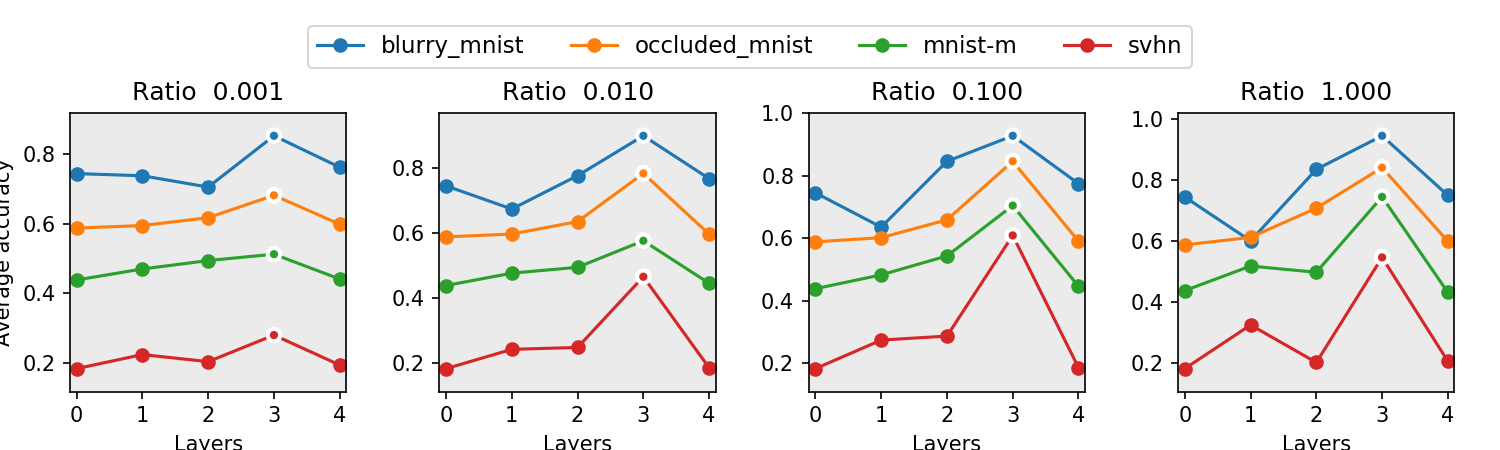



Ratio: 0.0010
Best layer, setting blurry_mnist 
   blurry_mnist in (mnist|blurry_mnist|mnist) : [ 3, 4, 0, 1, 2 ]
Best layer, setting occluded_mnist 
   occluded_mnist in (mnist|occluded_mnist|mnist) : [ 3, 2, 4, 1, 0 ]
Best layer, setting mnist-m 
   mnist-m in (mnist|mnist-m|mnist) : [ 3, 2, 1, 4, 0 ]
Best layer, setting svhn 
   svhn in (mnist|svhn|mnist) : [ 3, 1, 2, 4, 0 ]


Ratio: 0.0100
Best layer, setting blurry_mnist 
   blurry_mnist in (mnist|blurry_mnist|mnist) : [ 3, 2, 4, 0, 1 ]
Best layer, setting occluded_mnist 
   occluded_mnist in (mnist|occluded_mnist|mnist) : [ 3, 2, 1, 4, 0 ]
Best layer, setting mnist-m 
   mnist-m in (mnist|mnist-m|mnist) : [ 3, 2, 1, 4, 0 ]
Best layer, setting svhn 
   svhn in (mnist|svhn|mnist) : [ 3, 2, 1, 4, 0 ]


Ratio: 0.1000
Best layer, setting blurry_mnist 
   blurry_mnist in (mnist|blurry_mnist|mnist) : [ 3, 2, 4, 0, 1 ]
Best layer, setting occluded_mnist 
   occluded_mnist in (mnist|occluded_mnist|mnist) : [ 3, 2, 1, 4, 0 ]
Best layer, 

<IPython.core.display.Javascript object>


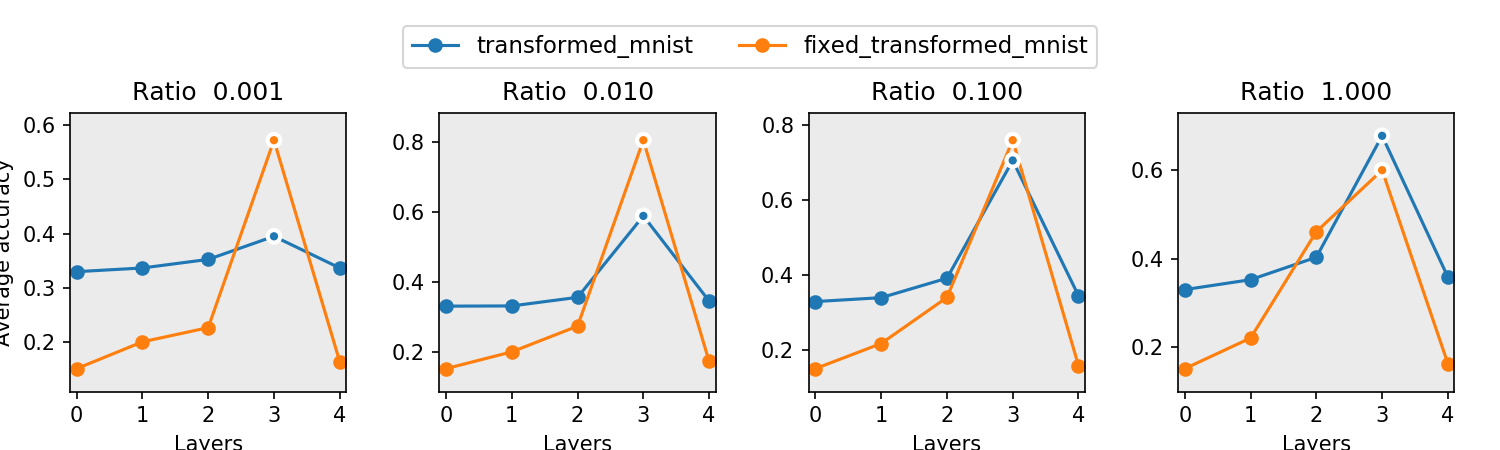



Ratio: 0.0010
Best layer, setting transformed_mnist 
   transformed_mnist in (mnist|transformed_mnist|mnist) : [ 3, 2, 1, 4, 0 ]
Best layer, setting fixed_transformed_mnist 
   fixed_transformed_mnist in (mnist|fixed_transformed_mnist|mnist) : [ 3, 2, 1, 4, 0 ]


Ratio: 0.0100
Best layer, setting transformed_mnist 
   transformed_mnist in (mnist|transformed_mnist|mnist) : [ 3, 2, 4, 1, 0 ]
Best layer, setting fixed_transformed_mnist 
   fixed_transformed_mnist in (mnist|fixed_transformed_mnist|mnist) : [ 3, 2, 1, 4, 0 ]


Ratio: 0.1000
Best layer, setting transformed_mnist 
   transformed_mnist in (mnist|transformed_mnist|mnist) : [ 3, 2, 4, 1, 0 ]
Best layer, setting fixed_transformed_mnist 
   fixed_transformed_mnist in (mnist|fixed_transformed_mnist|mnist) : [ 3, 2, 1, 4, 0 ]


Ratio: 1.0000
Best layer, setting transformed_mnist 
   transformed_mnist in (mnist|transformed_mnist|mnist) : [ 3, 2, 4, 1, 0 ]
Best layer, setting fixed_transformed_mnist 
   fixed_transformed_mnist in (m

<IPython.core.display.Javascript object>


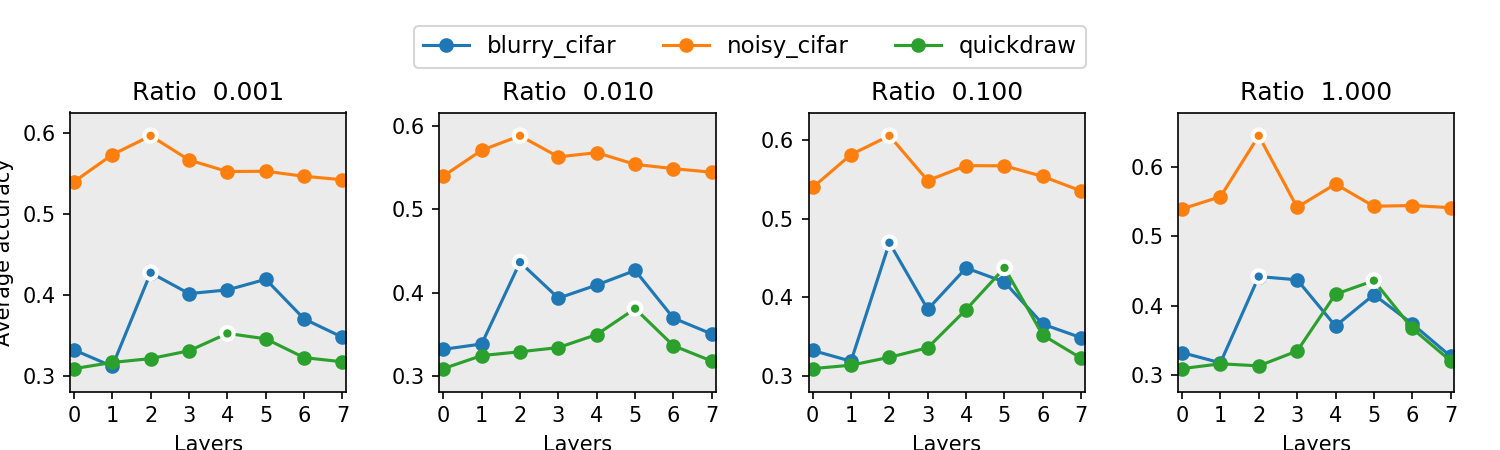



Ratio: 0.0010
Best layer, setting blurry_cifar 
   blurry_cifar in (cifar|blurry_cifar|cifar) : [ 2, 5, 4, 3, 6, 7, 0, 1 ]
Best layer, setting noisy_cifar 
   noisy_cifar in (cifar|noisy_cifar|cifar) : [ 2, 1, 3, 5, 4, 6, 7, 0 ]
Best layer, setting quickdraw 
   quickdraw in (cifar|quickdraw|cifar) : [ 4, 5, 3, 6, 2, 7, 1, 0 ]


Ratio: 0.0100
Best layer, setting blurry_cifar 
   blurry_cifar in (cifar|blurry_cifar|cifar) : [ 2, 5, 4, 3, 6, 7, 1, 0 ]
Best layer, setting noisy_cifar 
   noisy_cifar in (cifar|noisy_cifar|cifar) : [ 2, 1, 4, 3, 5, 6, 7, 0 ]
Best layer, setting quickdraw 
   quickdraw in (cifar|quickdraw|cifar) : [ 5, 4, 6, 3, 2, 1, 7, 0 ]


Ratio: 0.1000
Best layer, setting blurry_cifar 
   blurry_cifar in (cifar|blurry_cifar|cifar) : [ 2, 4, 5, 3, 6, 7, 0, 1 ]
Best layer, setting noisy_cifar 
   noisy_cifar in (cifar|noisy_cifar|cifar) : [ 2, 1, 4, 5, 6, 3, 0, 7 ]
Best layer, setting quickdraw 
   quickdraw in (cifar|quickdraw|cifar) : [ 5, 4, 6, 3, 2, 7, 1, 0 ]


Ratio

<IPython.core.display.Javascript object>


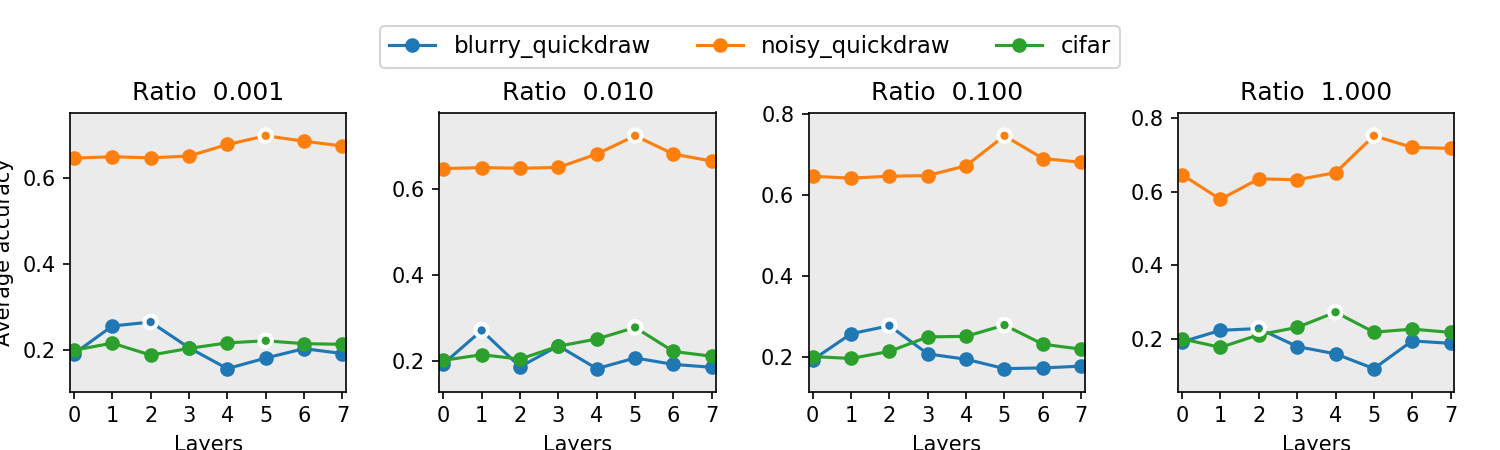



Ratio: 0.0010
Best layer, setting blurry_quickdraw 
   blurry_quickdraw in (quickdraw|blurry_quickdraw|quickdraw) : [ 2, 1, 3, 6, 7, 0, 5, 4 ]
Best layer, setting noisy_quickdraw 
   noisy_quickdraw in (quickdraw|noisy_quickdraw|quickdraw) : [ 5, 6, 4, 7, 3, 1, 2, 0 ]
Best layer, setting cifar 
   cifar in (quickdraw|cifar|quickdraw) : [ 5, 4, 1, 6, 7, 3, 0, 2 ]


Ratio: 0.0100
Best layer, setting blurry_quickdraw 
   blurry_quickdraw in (quickdraw|blurry_quickdraw|quickdraw) : [ 1, 3, 5, 0, 6, 2, 7, 4 ]
Best layer, setting noisy_quickdraw 
   noisy_quickdraw in (quickdraw|noisy_quickdraw|quickdraw) : [ 5, 4, 6, 7, 3, 1, 2, 0 ]
Best layer, setting cifar 
   cifar in (quickdraw|cifar|quickdraw) : [ 5, 4, 3, 6, 1, 7, 2, 0 ]


Ratio: 0.1000
Best layer, setting blurry_quickdraw 
   blurry_quickdraw in (quickdraw|blurry_quickdraw|quickdraw) : [ 2, 1, 3, 4, 0, 7, 6, 5 ]
Best layer, setting noisy_quickdraw 
   noisy_quickdraw in (quickdraw|noisy_quickdraw|quickdraw) : [ 5, 6, 7, 4, 3, 2, 0,

<IPython.core.display.Javascript object>


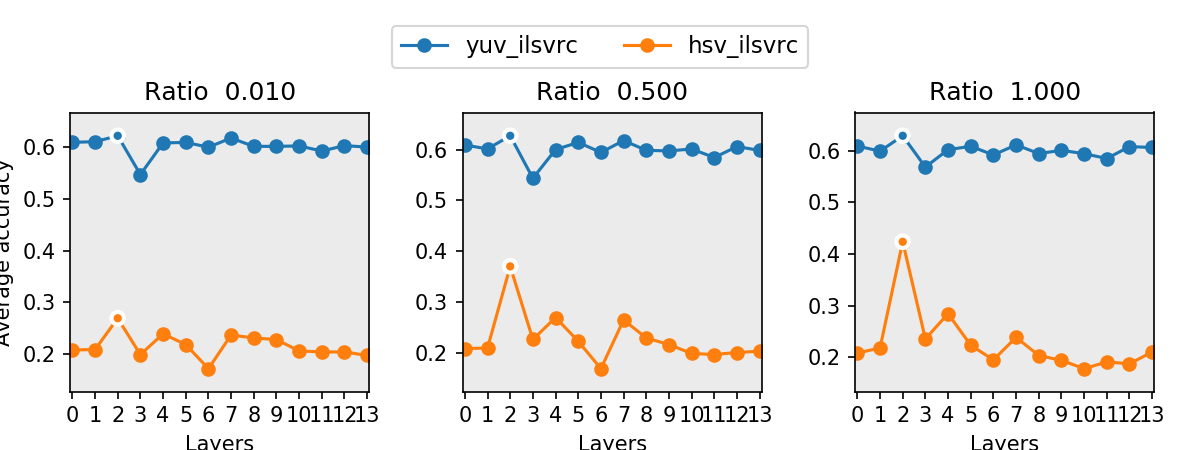



Ratio: 0.0100
Best layer, setting yuv_ilsvrc 
   yuv_ilsvrc in (ilsvrc2012|yuv_ilsvrc|ilsvrc2012) : [ 2, 7, 1, 0, 5, 4, 12, 10, 8, 9, 13, 6, 11, 3 ]
Best layer, setting hsv_ilsvrc 
   hsv_ilsvrc in (ilsvrc2012|hsv_ilsvrc|ilsvrc2012) : [ 2, 4, 7, 8, 9, 5, 1, 0, 10, 11, 12, 3, 13, 6 ]


Ratio: 0.5000
Best layer, setting yuv_ilsvrc 
   yuv_ilsvrc in (ilsvrc2012|yuv_ilsvrc|ilsvrc2012) : [ 2, 7, 5, 0, 12, 1, 10, 4, 8, 13, 9, 6, 11, 3 ]
Best layer, setting hsv_ilsvrc 
   hsv_ilsvrc in (ilsvrc2012|hsv_ilsvrc|ilsvrc2012) : [ 2, 4, 7, 8, 3, 5, 9, 1, 0, 13, 12, 10, 11, 6 ]


Ratio: 1.0000
Best layer, setting yuv_ilsvrc 
   yuv_ilsvrc in (ilsvrc2012|yuv_ilsvrc|ilsvrc2012) : [ 2, 7, 0, 5, 12, 13, 4, 9, 1, 8, 10, 6, 11, 3 ]
Best layer, setting hsv_ilsvrc 
   hsv_ilsvrc in (ilsvrc2012|hsv_ilsvrc|ilsvrc2012) : [ 2, 4, 7, 3, 5, 1, 13, 0, 8, 6, 9, 11, 12, 10 ]


Dataset: spatial_ilsvrc


<IPython.core.display.Javascript object>


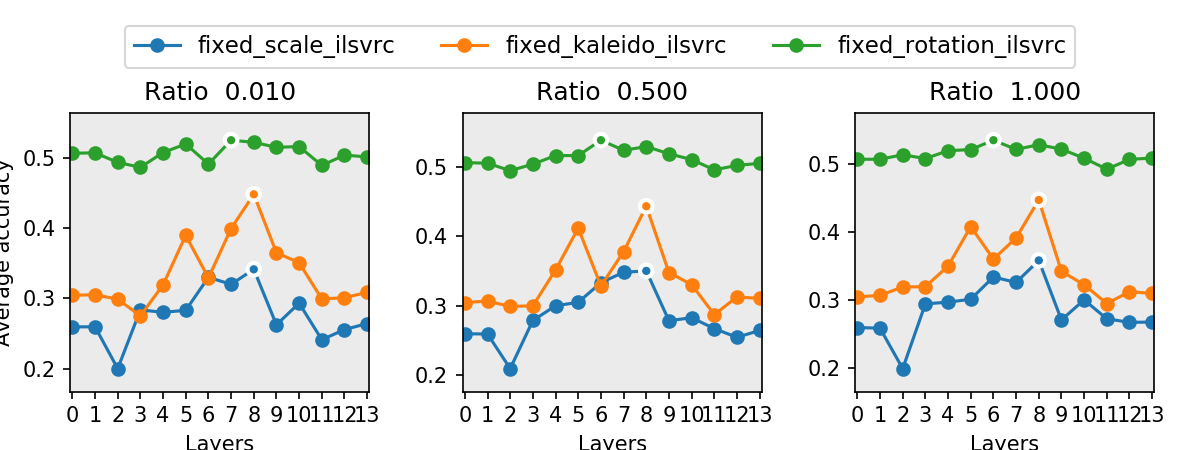



Ratio: 0.0100
Best layer, setting fixed_scale_ilsvrc 
   fixed_scale_ilsvrc in (ilsvrc2012|fixed_scale_ilsvrc|ilsvrc2012) : [ 8, 6, 7, 10, 3, 5, 4, 13, 9, 1, 0, 12, 11, 2 ]
Best layer, setting fixed_kaleido_ilsvrc 
   fixed_kaleido_ilsvrc in (ilsvrc2012|fixed_kaleido_ilsvrc|ilsvrc2012) : [ 8, 7, 5, 9, 10, 6, 4, 13, 1, 0, 12, 11, 2, 3 ]
Best layer, setting fixed_rotation_ilsvrc 
   fixed_rotation_ilsvrc in (ilsvrc2012|fixed_rotation_ilsvrc|ilsvrc2012) : [ 7, 8, 5, 10, 9, 4, 1, 0, 12, 13, 2, 6, 11, 3 ]


Ratio: 0.5000
Best layer, setting fixed_scale_ilsvrc 
   fixed_scale_ilsvrc in (ilsvrc2012|fixed_scale_ilsvrc|ilsvrc2012) : [ 8, 7, 6, 5, 4, 10, 3, 9, 11, 13, 0, 1, 12, 2 ]
Best layer, setting fixed_kaleido_ilsvrc 
   fixed_kaleido_ilsvrc in (ilsvrc2012|fixed_kaleido_ilsvrc|ilsvrc2012) : [ 8, 5, 7, 4, 9, 10, 6, 12, 13, 1, 0, 3, 2, 11 ]
Best layer, setting fixed_rotation_ilsvrc 
   fixed_rotation_ilsvrc in (ilsvrc2012|fixed_rotation_ilsvrc|ilsvrc2012) : [ 6, 8, 7, 9, 4, 5, 10, 0, 1, 13,

<IPython.core.display.Javascript object>


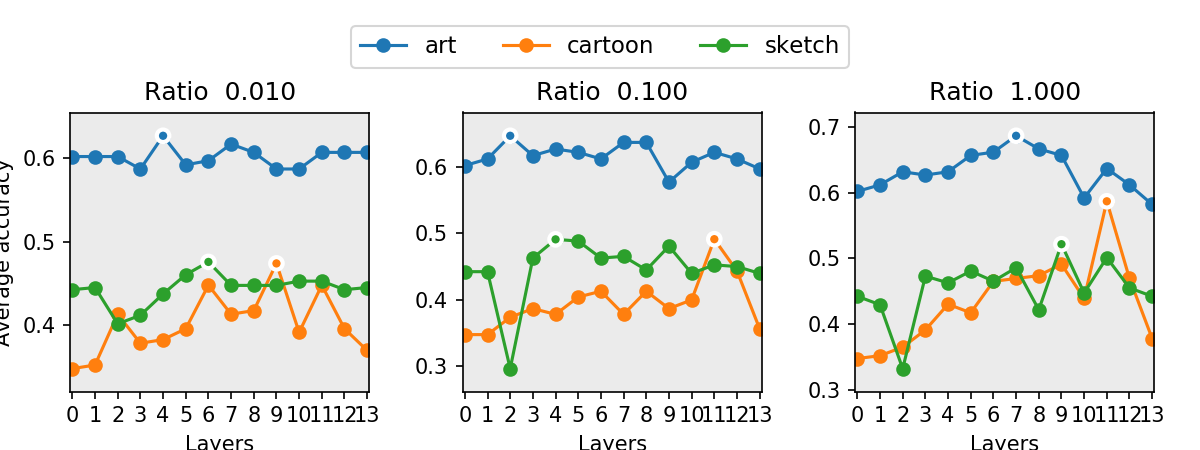



Ratio: 0.0100
Best layer, setting art 
   art in (photo|art|photo) : [ 4, 7, 8, 11, 12, 13, 0, 1, 2, 6, 5, 3, 9, 10 ]
Best layer, setting cartoon 
   cartoon in (photo|cartoon|photo) : [ 9, 6, 11, 8, 2, 7, 5, 12, 10, 4, 3, 13, 1, 0 ]
Best layer, setting sketch 
   sketch in (photo|sketch|photo) : [ 6, 5, 10, 11, 7, 8, 9, 1, 13, 0, 12, 4, 3, 2 ]


Ratio: 0.1000
Best layer, setting art 
   art in (photo|art|photo) : [ 2, 7, 8, 4, 5, 11, 3, 1, 6, 12, 10, 0, 13, 9 ]
Best layer, setting cartoon 
   cartoon in (photo|cartoon|photo) : [ 11, 12, 6, 8, 5, 10, 3, 9, 4, 7, 2, 13, 0, 1 ]
Best layer, setting sketch 
   sketch in (photo|sketch|photo) : [ 4, 5, 9, 7, 3, 6, 11, 12, 8, 0, 1, 10, 13, 2 ]


Ratio: 1.0000
Best layer, setting art 
   art in (photo|art|photo) : [ 7, 8, 6, 5, 9, 11, 2, 4, 3, 1, 12, 0, 10, 13 ]
Best layer, setting cartoon 
   cartoon in (photo|cartoon|photo) : [ 11, 9, 8, 7, 12, 6, 10, 4, 5, 3, 13, 2, 1, 0 ]
Best layer, setting sketch 
   sketch in (photo|sketch|photo) : [ 

In [50]:
get_criterion(restore='pointwise', split='val', one_epoch=False, verbose=False)

# Second criterion (faster-flex)
  * fine tune pretrained A  all on train set of B fpr **one epoch**
  * Get val accuracy of dataset A in model A (+ insert one middle layer of B)
  * Get val accuracy of dataset B in model B (+ insert one middle layer of A)

Restore pointwise on split val with 'log' log/one_epoch


Dataset: mnist


<IPython.core.display.Javascript object>


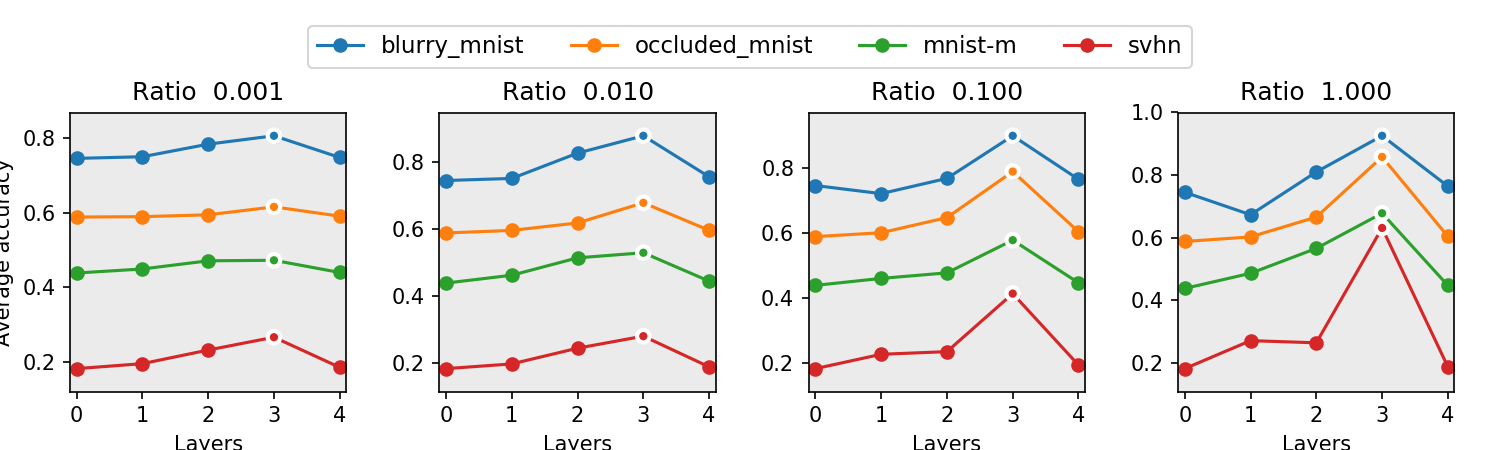



Ratio: 0.0010
Best layer, setting blurry_mnist 
   blurry_mnist in (mnist|blurry_mnist|mnist) : [ 3, 2, 1, 4, 0 ]
Best layer, setting occluded_mnist 
   occluded_mnist in (mnist|occluded_mnist|mnist) : [ 3, 2, 4, 1, 0 ]
Best layer, setting mnist-m 
   mnist-m in (mnist|mnist-m|mnist) : [ 3, 2, 1, 4, 0 ]
Best layer, setting svhn 
   svhn in (mnist|svhn|mnist) : [ 3, 2, 1, 4, 0 ]


Ratio: 0.0100
Best layer, setting blurry_mnist 
   blurry_mnist in (mnist|blurry_mnist|mnist) : [ 3, 2, 4, 1, 0 ]
Best layer, setting occluded_mnist 
   occluded_mnist in (mnist|occluded_mnist|mnist) : [ 3, 2, 4, 1, 0 ]
Best layer, setting mnist-m 
   mnist-m in (mnist|mnist-m|mnist) : [ 3, 2, 1, 4, 0 ]
Best layer, setting svhn 
   svhn in (mnist|svhn|mnist) : [ 3, 2, 1, 4, 0 ]


Ratio: 0.1000
Best layer, setting blurry_mnist 
   blurry_mnist in (mnist|blurry_mnist|mnist) : [ 3, 2, 4, 0, 1 ]
Best layer, setting occluded_mnist 
   occluded_mnist in (mnist|occluded_mnist|mnist) : [ 3, 2, 4, 1, 0 ]
Best layer, 

<IPython.core.display.Javascript object>


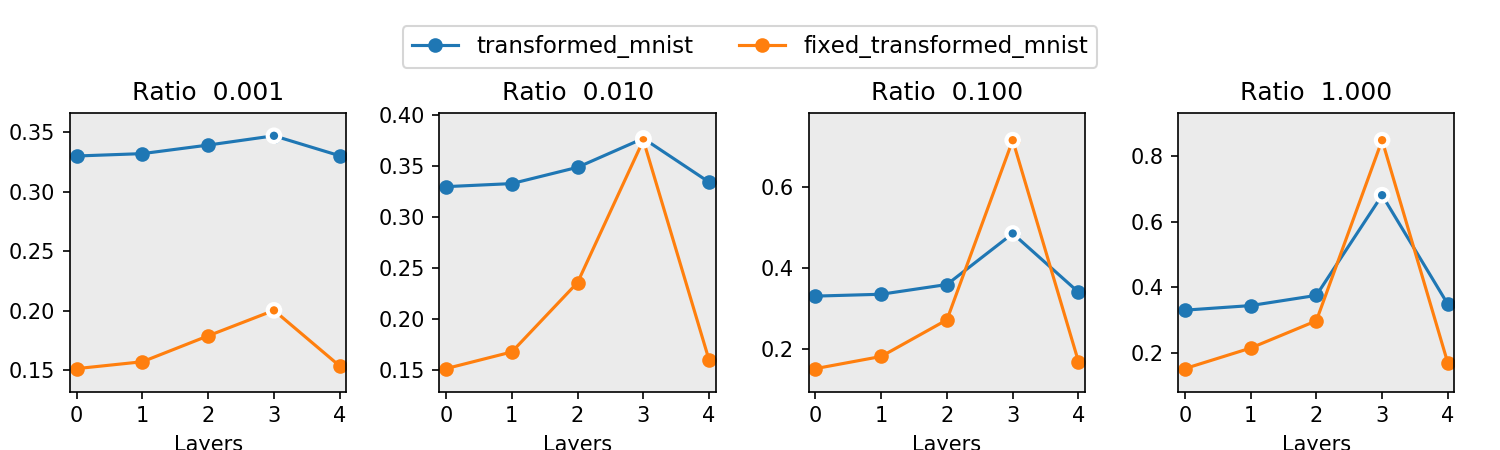



Ratio: 0.0010
Best layer, setting transformed_mnist 
   transformed_mnist in (mnist|transformed_mnist|mnist) : [ 3, 2, 1, 4, 0 ]
Best layer, setting fixed_transformed_mnist 
   fixed_transformed_mnist in (mnist|fixed_transformed_mnist|mnist) : [ 3, 2, 1, 4, 0 ]


Ratio: 0.0100
Best layer, setting transformed_mnist 
   transformed_mnist in (mnist|transformed_mnist|mnist) : [ 3, 2, 4, 1, 0 ]
Best layer, setting fixed_transformed_mnist 
   fixed_transformed_mnist in (mnist|fixed_transformed_mnist|mnist) : [ 3, 2, 1, 4, 0 ]


Ratio: 0.1000
Best layer, setting transformed_mnist 
   transformed_mnist in (mnist|transformed_mnist|mnist) : [ 3, 2, 4, 1, 0 ]
Best layer, setting fixed_transformed_mnist 
   fixed_transformed_mnist in (mnist|fixed_transformed_mnist|mnist) : [ 3, 2, 1, 4, 0 ]


Ratio: 1.0000
Best layer, setting transformed_mnist 
   transformed_mnist in (mnist|transformed_mnist|mnist) : [ 3, 2, 4, 1, 0 ]
Best layer, setting fixed_transformed_mnist 
   fixed_transformed_mnist in (m

<IPython.core.display.Javascript object>


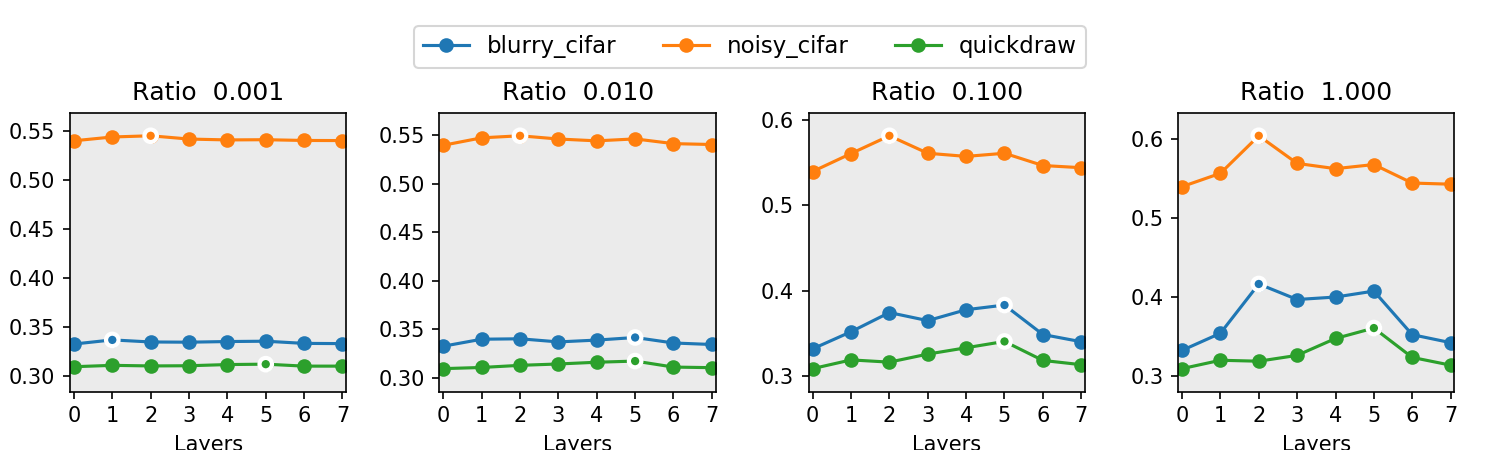



Ratio: 0.0010
Best layer, setting blurry_cifar 
   blurry_cifar in (cifar|blurry_cifar|cifar) : [ 1, 5, 4, 2, 3, 6, 7, 0 ]
Best layer, setting noisy_cifar 
   noisy_cifar in (cifar|noisy_cifar|cifar) : [ 2, 1, 3, 5, 4, 6, 7, 0 ]
Best layer, setting quickdraw 
   quickdraw in (cifar|quickdraw|cifar) : [ 5, 4, 1, 3, 2, 6, 7, 0 ]


Ratio: 0.0100
Best layer, setting blurry_cifar 
   blurry_cifar in (cifar|blurry_cifar|cifar) : [ 5, 2, 1, 4, 3, 6, 7, 0 ]
Best layer, setting noisy_cifar 
   noisy_cifar in (cifar|noisy_cifar|cifar) : [ 2, 1, 5, 3, 4, 6, 7, 0 ]
Best layer, setting quickdraw 
   quickdraw in (cifar|quickdraw|cifar) : [ 5, 4, 3, 2, 6, 1, 7, 0 ]


Ratio: 0.1000
Best layer, setting blurry_cifar 
   blurry_cifar in (cifar|blurry_cifar|cifar) : [ 5, 4, 2, 3, 1, 6, 7, 0 ]
Best layer, setting noisy_cifar 
   noisy_cifar in (cifar|noisy_cifar|cifar) : [ 2, 3, 5, 1, 4, 6, 7, 0 ]
Best layer, setting quickdraw 
   quickdraw in (cifar|quickdraw|cifar) : [ 5, 4, 3, 1, 6, 2, 7, 0 ]


Ratio

<IPython.core.display.Javascript object>


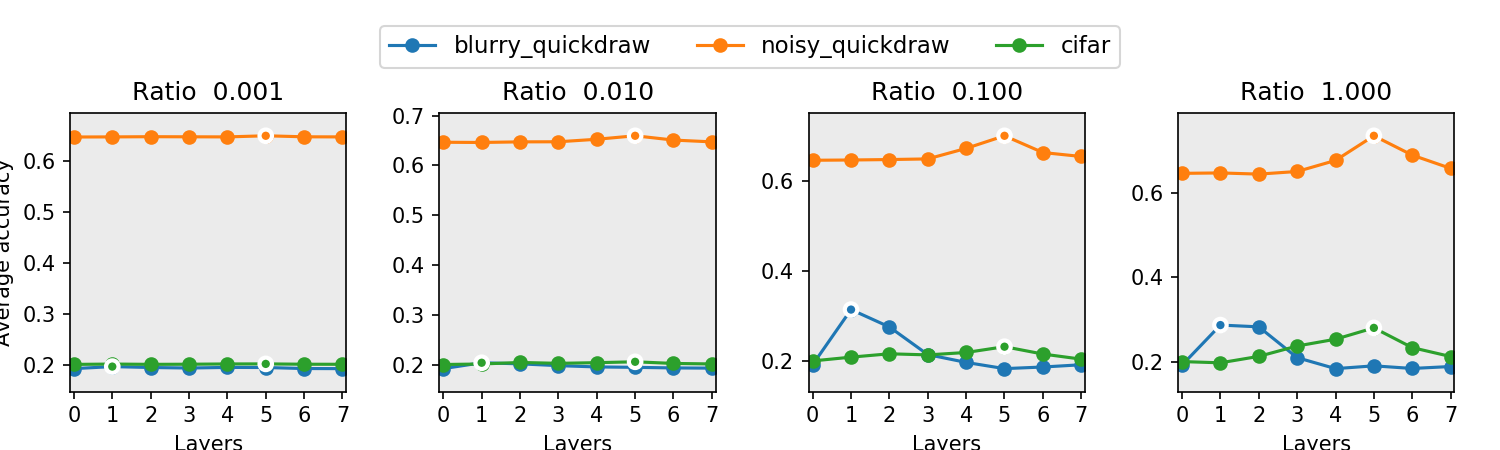



Ratio: 0.0010
Best layer, setting blurry_quickdraw 
   blurry_quickdraw in (quickdraw|blurry_quickdraw|quickdraw) : [ 1, 4, 2, 5, 3, 6, 0, 7 ]
Best layer, setting noisy_quickdraw 
   noisy_quickdraw in (quickdraw|noisy_quickdraw|quickdraw) : [ 5, 2, 3, 6, 1, 4, 7, 0 ]
Best layer, setting cifar 
   cifar in (quickdraw|cifar|quickdraw) : [ 5, 4, 1, 3, 6, 7, 2, 0 ]


Ratio: 0.0100
Best layer, setting blurry_quickdraw 
   blurry_quickdraw in (quickdraw|blurry_quickdraw|quickdraw) : [ 1, 2, 3, 4, 5, 6, 7, 0 ]
Best layer, setting noisy_quickdraw 
   noisy_quickdraw in (quickdraw|noisy_quickdraw|quickdraw) : [ 5, 4, 6, 3, 2, 7, 0, 1 ]
Best layer, setting cifar 
   cifar in (quickdraw|cifar|quickdraw) : [ 5, 2, 4, 3, 6, 7, 1, 0 ]


Ratio: 0.1000
Best layer, setting blurry_quickdraw 
   blurry_quickdraw in (quickdraw|blurry_quickdraw|quickdraw) : [ 1, 2, 3, 4, 0, 7, 6, 5 ]
Best layer, setting noisy_quickdraw 
   noisy_quickdraw in (quickdraw|noisy_quickdraw|quickdraw) : [ 5, 4, 6, 7, 3, 2, 1,

<IPython.core.display.Javascript object>


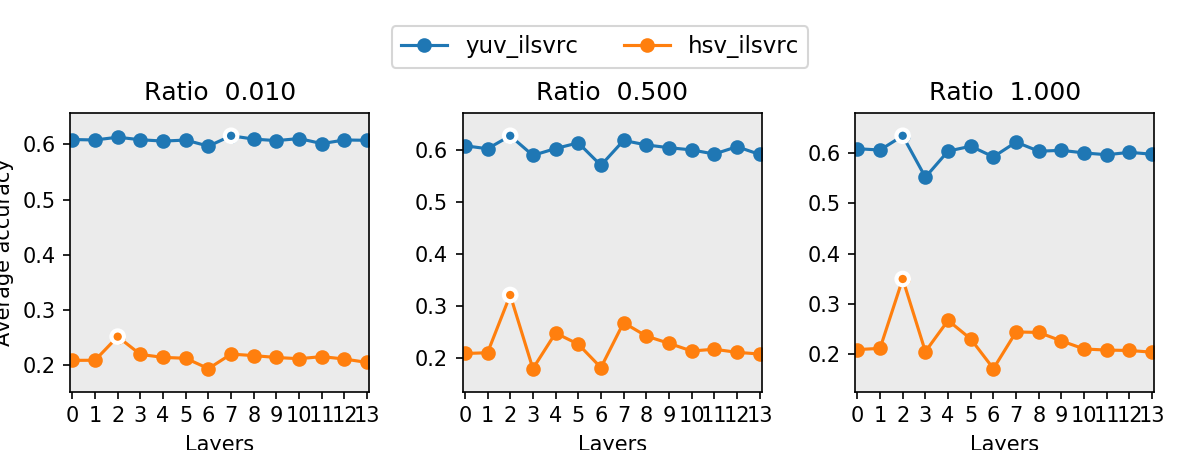



Ratio: 0.0100
Best layer, setting yuv_ilsvrc 
   yuv_ilsvrc in (ilsvrc2012|yuv_ilsvrc|ilsvrc2012) : [ 7, 2, 10, 8, 0, 3, 1, 12, 5, 13, 9, 4, 11, 6 ]
Best layer, setting hsv_ilsvrc 
   hsv_ilsvrc in (ilsvrc2012|hsv_ilsvrc|ilsvrc2012) : [ 2, 7, 3, 8, 11, 4, 9, 5, 10, 12, 1, 0, 13, 6 ]


Ratio: 0.5000
Best layer, setting yuv_ilsvrc 
   yuv_ilsvrc in (ilsvrc2012|yuv_ilsvrc|ilsvrc2012) : [ 2, 7, 5, 8, 0, 12, 9, 4, 1, 10, 11, 13, 3, 6 ]
Best layer, setting hsv_ilsvrc 
   hsv_ilsvrc in (ilsvrc2012|hsv_ilsvrc|ilsvrc2012) : [ 2, 7, 4, 8, 9, 5, 11, 10, 12, 1, 0, 13, 6, 3 ]


Ratio: 1.0000
Best layer, setting yuv_ilsvrc 
   yuv_ilsvrc in (ilsvrc2012|yuv_ilsvrc|ilsvrc2012) : [ 2, 7, 5, 0, 1, 9, 4, 8, 12, 10, 13, 11, 6, 3 ]
Best layer, setting hsv_ilsvrc 
   hsv_ilsvrc in (ilsvrc2012|hsv_ilsvrc|ilsvrc2012) : [ 2, 4, 7, 8, 5, 9, 1, 10, 0, 11, 12, 3, 13, 6 ]


Dataset: spatial_ilsvrc


<IPython.core.display.Javascript object>


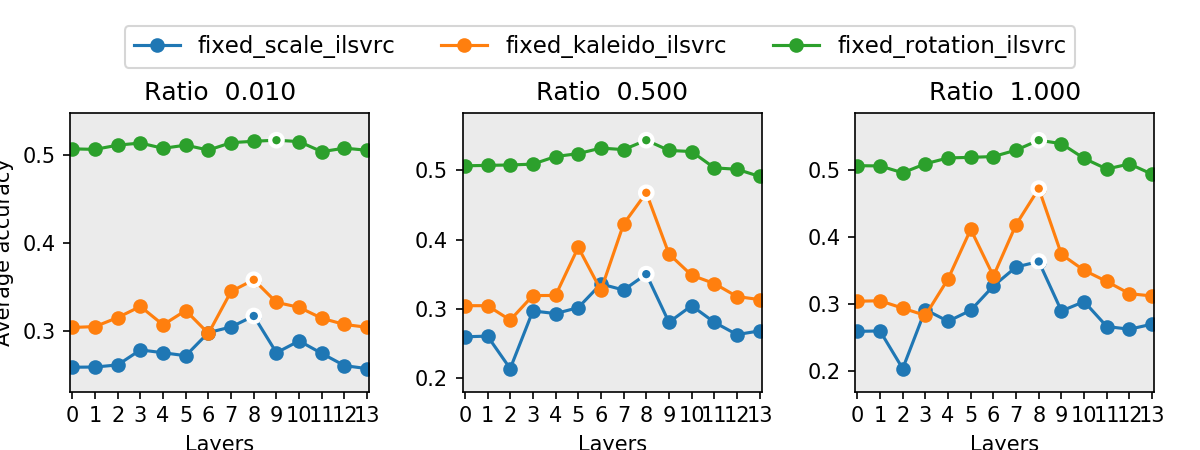



Ratio: 0.0100
Best layer, setting fixed_scale_ilsvrc 
   fixed_scale_ilsvrc in (ilsvrc2012|fixed_scale_ilsvrc|ilsvrc2012) : [ 8, 7, 6, 10, 3, 4, 9, 11, 5, 2, 12, 1, 0, 13 ]
Best layer, setting fixed_kaleido_ilsvrc 
   fixed_kaleido_ilsvrc in (ilsvrc2012|fixed_kaleido_ilsvrc|ilsvrc2012) : [ 8, 7, 9, 3, 10, 5, 2, 11, 12, 4, 1, 13, 0, 6 ]
Best layer, setting fixed_rotation_ilsvrc 
   fixed_rotation_ilsvrc in (ilsvrc2012|fixed_rotation_ilsvrc|ilsvrc2012) : [ 9, 8, 10, 7, 3, 2, 5, 12, 4, 0, 1, 6, 13, 11 ]


Ratio: 0.5000
Best layer, setting fixed_scale_ilsvrc 
   fixed_scale_ilsvrc in (ilsvrc2012|fixed_scale_ilsvrc|ilsvrc2012) : [ 8, 6, 7, 10, 5, 3, 4, 9, 11, 13, 12, 1, 0, 2 ]
Best layer, setting fixed_kaleido_ilsvrc 
   fixed_kaleido_ilsvrc in (ilsvrc2012|fixed_kaleido_ilsvrc|ilsvrc2012) : [ 8, 7, 5, 9, 10, 11, 6, 4, 3, 12, 13, 0, 1, 2 ]
Best layer, setting fixed_rotation_ilsvrc 
   fixed_rotation_ilsvrc in (ilsvrc2012|fixed_rotation_ilsvrc|ilsvrc2012) : [ 8, 6, 7, 9, 10, 5, 4, 3, 2, 1, 

<IPython.core.display.Javascript object>


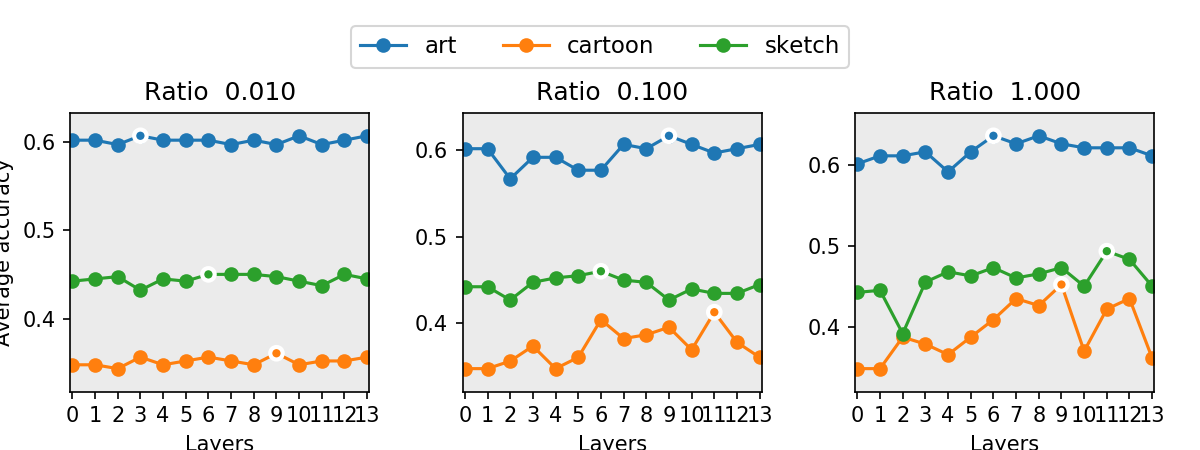



Ratio: 0.0100
Best layer, setting art 
   art in (photo|art|photo) : [ 3, 10, 13, 0, 1, 4, 5, 6, 8, 12, 2, 7, 9, 11 ]
Best layer, setting cartoon 
   cartoon in (photo|cartoon|photo) : [ 9, 3, 6, 13, 5, 7, 11, 12, 0, 1, 4, 8, 10, 2 ]
Best layer, setting sketch 
   sketch in (photo|sketch|photo) : [ 6, 7, 8, 12, 2, 9, 1, 4, 13, 0, 5, 10, 11, 3 ]


Ratio: 0.1000
Best layer, setting art 
   art in (photo|art|photo) : [ 9, 7, 10, 13, 0, 1, 8, 12, 11, 3, 4, 5, 6, 2 ]
Best layer, setting cartoon 
   cartoon in (photo|cartoon|photo) : [ 11, 6, 9, 8, 7, 12, 3, 10, 5, 13, 2, 0, 1, 4 ]
Best layer, setting sketch 
   sketch in (photo|sketch|photo) : [ 6, 5, 4, 7, 3, 8, 13, 0, 1, 10, 11, 12, 2, 9 ]


Ratio: 1.0000
Best layer, setting art 
   art in (photo|art|photo) : [ 6, 8, 7, 9, 10, 11, 12, 3, 5, 1, 2, 13, 0, 4 ]
Best layer, setting cartoon 
   cartoon in (photo|cartoon|photo) : [ 9, 7, 12, 8, 11, 6, 2, 5, 3, 10, 4, 13, 0, 1 ]
Best layer, setting sketch 
   sketch in (photo|sketch|photo) : [ 

In [51]:
get_criterion(restore='pointwise', split='val', one_epoch=True, verbose=False)